In [3]:
# Configuration Cell - Environment Detection
import os
import sys
from pathlib import Path

# Detect environment
IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'google.colab' in sys.modules

# Set base directories based on environment
if IS_KAGGLE:
    PROJECT_ROOT = Path("/kaggle/working")
    DATA_DIR = Path("/kaggle/input/ood-eval-toxic-classifiers/data")
elif IS_COLAB:
    PROJECT_ROOT = Path("/content")
    DATA_DIR = PROJECT_ROOT / "data"
else:
    # Local environment - use parent of notebooks folder
    PROJECT_ROOT = Path(__file__).parent.parent if '__file__' in dir() else Path.cwd().parent
    if not (PROJECT_ROOT / "data").exists():
        PROJECT_ROOT = Path.cwd().parent  # Fallback
    DATA_DIR = PROJECT_ROOT / "data"

# Standard directories
EXPERIMENTS_DIR = PROJECT_ROOT / "experiments"
PLOTS_DIR = EXPERIMENTS_DIR / "plots"

# Create directories if needed
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Environment: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Experiments directory: {EXPERIMENTS_DIR}")
print(f"Plots directory: {PLOTS_DIR}")

Environment: Local
Project root: /workspaces/ood-eval-toxic-classifiers
Data directory: /workspaces/ood-eval-toxic-classifiers/data
Experiments directory: /workspaces/ood-eval-toxic-classifiers/experiments
Plots directory: /workspaces/ood-eval-toxic-classifiers/experiments/plots


In [4]:
# Analysis and Visualization Notebook
# Run this after training models and computing fairness metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc, average_precision_score

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("Analysis and Plotting Notebook")
print(f"Experiments directory: {EXPERIMENTS_DIR}")
print(f"Plots will be saved to: {PLOTS_DIR}")

# Check if experiments directory has any data
exp_files = list(EXPERIMENTS_DIR.glob("*.csv"))
if not exp_files:
    print("\n⚠️  WARNING: No experiment files found!")
    print("Please run training scripts first:")
    print("  - run_roberta.py")
    print("  - run_tfidf_baselines.py")
else:
    print(f"\n✓ Found {len(exp_files)} experiment files:")
    for f in sorted(exp_files):
        print(f"  - {f.name}")

Analysis and Plotting Notebook
Experiments directory: /workspaces/ood-eval-toxic-classifiers/experiments
Plots will be saved to: /workspaces/ood-eval-toxic-classifiers/experiments/plots

✓ Found 16 experiment files:
  - fairness_jigsaw_test_per_group.csv
  - fairness_jigsaw_test_summary.csv
  - fairness_test_per_group.csv
  - fairness_test_summary.csv
  - preds_tfidf_logreg_jigsaw_test.csv
  - preds_tfidf_logreg_jigsaw_to_civil.csv
  - preds_tfidf_logreg_jigsaw_to_hatexplain.csv
  - preds_tfidf_svm_civil_test.csv
  - preds_tfidf_svm_civil_to_hatexplain.csv
  - preds_tfidf_svm_civil_to_jigsaw.csv
  - preds_tfidf_svm_hatexplain_test.csv
  - preds_tfidf_svm_hatexplain_to_jigsaw.csv
  - summary_tfidf_civil_svm.csv
  - summary_tfidf_hatexplain_logreg.csv
  - summary_tfidf_hatexplain_svm.csv
  - summary_tfidf_jigsaw_logreg.csv


In [5]:
# Load summary metrics from experiments
def load_summary_metrics(source_dataset, model_type="roberta"):
    """Load summary CSV for a given source and model type."""
    if model_type == "roberta":
        path = EXPERIMENTS_DIR / f"summary_{source_dataset}.csv"
    else:
        path = EXPERIMENTS_DIR / f"summary_tfidf_{source_dataset}_{model_type}.csv"
    
    if path.exists():
        df = pd.read_csv(path)
        print(f"✓ Loaded {path.name}: {len(df)} rows")
        return df
    else:
        print(f"[INFO] File not found: {path.name}")
        return None

# Load available summaries
print("Loading summary metrics...\n")
jigsaw_roberta = load_summary_metrics("jigsaw", "roberta")
jigsaw_tfidf_lr = load_summary_metrics("jigsaw", "logreg")
jigsaw_tfidf_svm = load_summary_metrics("jigsaw", "svm")
civil_tfidf_svm = load_summary_metrics("civil", "svm")
hatexplain_tfidf_svm = load_summary_metrics("hatexplain", "svm")
hatexplain_tfidf_lr = load_summary_metrics("hatexplain", "logreg")

# Display available data
print("\n" + "="*50)
print("Available summary data:")
for name, df in [("Jigsaw RoBERTa", jigsaw_roberta), 
                 ("Jigsaw TF-IDF LR", jigsaw_tfidf_lr),
                 ("Jigsaw TF-IDF SVM", jigsaw_tfidf_svm),
                 ("Civil TF-IDF SVM", civil_tfidf_svm),
                 ("HateXplain TF-IDF SVM", hatexplain_tfidf_svm)]:
    if df is not None:
        print(f"  ✓ {name}")
        display(df)

Loading summary metrics...

[INFO] File not found: summary_jigsaw.csv
✓ Loaded summary_tfidf_jigsaw_logreg.csv: 3 rows
[INFO] File not found: summary_tfidf_jigsaw_svm.csv
✓ Loaded summary_tfidf_civil_svm.csv: 4 rows
✓ Loaded summary_tfidf_hatexplain_svm.csv: 3 rows
✓ Loaded summary_tfidf_hatexplain_logreg.csv: 3 rows

Available summary data:
  ✓ Jigsaw TF-IDF LR


,split,accuracy,f1,auroc,pr_auc,nll,brier
0,in_domain_val,1.000000,1.0,1.000000,1.000000,0.072329,0.005842
1,in_domain_test,1.000000,1.0,1.000000,1.000000,0.072864,0.006074
2,cross_hatexplain,0.404276,0.0,0.490871,0.587823,1.499540,0.495360


  ✓ Civil TF-IDF SVM


,split,accuracy,f1,auroc,pr_auc,nll,brier
0,in_domain_val,1.0,1.0,1.0,1.0,NaN,NaN
1,in_domain_test,1.0,1.0,1.0,1.0,NaN,NaN
2,cross_jigsaw,1.0,1.0,1.0,1.0,NaN,NaN
3,cross_hatexplain,1.0,1.0,1.0,1.0,NaN,NaN


  ✓ HateXplain TF-IDF SVM


,split,accuracy,f1,auroc,pr_auc,nll,brier
0,in_domain_val,0.728493,0.775678,0.799275,0.852822,NaN,NaN
1,in_domain_test,0.735455,0.781967,0.816607,0.872647,NaN,NaN
2,cross_jigsaw,0.490000,0.190476,0.388095,0.261509,NaN,NaN


In [6]:
# 1. RELIABILITY DIAGRAMS

def plot_reliability_diagram(csv_path, title="Reliability Diagram", save_path=None):
    """
    Plot reliability diagram from binned statistics CSV.
    
    Args:
        csv_path: Path to reliability CSV with columns: bin, left, right, count, acc, conf, gap
        title: Plot title
        save_path: Where to save the plot (if None, just display)
    """
    df = pd.read_csv(csv_path)
    
    # Filter out empty bins
    df = df[df['count'] > 0].copy()
    
    if len(df) == 0:
        print(f"[WARN] No valid bins in {csv_path}")
        return
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot points
    ax.scatter(df['conf'], df['acc'], s=df['count']/df['count'].max()*500, 
               alpha=0.6, c='steelblue', edgecolors='black', linewidths=1)
    
    # Perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
    
    # Labels and formatting
    ax.set_xlabel('Confidence (Mean Predicted Probability)', fontsize=12)
    ax.set_ylabel('Accuracy (Fraction of Positives)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Plot reliability diagram for Jigsaw validation
reliability_csv = Path(EXPERIMENTS_DIR) / "jigsaw_val_reliability.csv"
if reliability_csv.exists():
    plot_reliability_diagram(
        reliability_csv,
        title="Reliability Diagram: Jigsaw Validation Set",
        save_path=os.path.join(PLOTS_DIR, "reliability_jigsaw_val.png")
    )

In [7]:
# 2. ROC CURVES

def plot_roc_curve(pred_csv_path, title="ROC Curve", save_path=None):
    """
    Plot ROC curve from predictions CSV.
    
    Args:
        pred_csv_path: Path to predictions CSV with columns: label, score (or pos_prob)
        title: Plot title
        save_path: Where to save
    """
    df = pd.read_csv(pred_csv_path)
    
    # Determine score column
    score_col = "pos_prob" if "pos_prob" in df.columns else "score"
    
    if score_col not in df.columns or "label" not in df.columns:
        print(f"[WARN] Missing required columns in {pred_csv_path}")
        return
    
    y_true = df["label"].values
    y_score = df[score_col].values
    
    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    
    from sklearn.metrics import auc
    roc_auc = auc(fpr, tpr)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example: Plot ROC for in-domain test
test_preds = Path(EXPERIMENTS_DIR) / "preds_jigsaw_test.csv"
if test_preds.exists():
    plot_roc_curve(
        test_preds,
        title="ROC Curve: Jigsaw Test Set (RoBERTa)",
        save_path=os.path.join(PLOTS_DIR, "roc_jigsaw_test.png")
    )

In [8]:
# 3. PRECISION-RECALL CURVES

def plot_pr_curve(pred_csv_path, title="Precision-Recall Curve", save_path=None):
    """Plot Precision-Recall curve from predictions CSV."""
    df = pd.read_csv(pred_csv_path)
    
    score_col = "pos_prob" if "pos_prob" in df.columns else "score"
    
    if score_col not in df.columns or "label" not in df.columns:
        print(f"[WARN] Missing required columns in {pred_csv_path}")
        return
    
    y_true = df["label"].values
    y_score = df[score_col].values
    
    # Compute PR curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    
    from sklearn.metrics import average_precision_score
    avg_precision = average_precision_score(y_true, y_score)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(recall, precision, color='purple', lw=2, 
            label=f'PR curve (AP = {avg_precision:.3f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc="lower left", fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example: Plot PR curve
if test_preds.exists():
    plot_pr_curve(
        test_preds,
        title="Precision-Recall Curve: Jigsaw Test Set (RoBERTa)",
        save_path=os.path.join(PLOTS_DIR, "pr_jigsaw_test.png")
    )

In [9]:
# 4. CONFUSION MATRICES

def plot_confusion_matrix(pred_csv_path, title="Confusion Matrix", save_path=None):
    """Plot confusion matrix heatmap from predictions CSV."""
    df = pd.read_csv(pred_csv_path)
    
    if "label" not in df.columns or "pred" not in df.columns:
        print(f"[WARN] Missing 'label' or 'pred' columns in {pred_csv_path}")
        return
    
    y_true = df["label"].values
    y_pred = df["pred"].values
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Toxic', 'Toxic'],
                yticklabels=['Non-Toxic', 'Toxic'],
                cbar_kws={'label': 'Count'},
                ax=ax)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example: Confusion matrix for test set
if test_preds.exists():
    plot_confusion_matrix(
        test_preds,
        title="Confusion Matrix: Jigsaw Test Set (RoBERTa)",
        save_path=os.path.join(PLOTS_DIR, "cm_jigsaw_test.png")
    )

Saved: /workspaces/ood-eval-toxic-classifiers/experiments/plots/comparison_f1.png


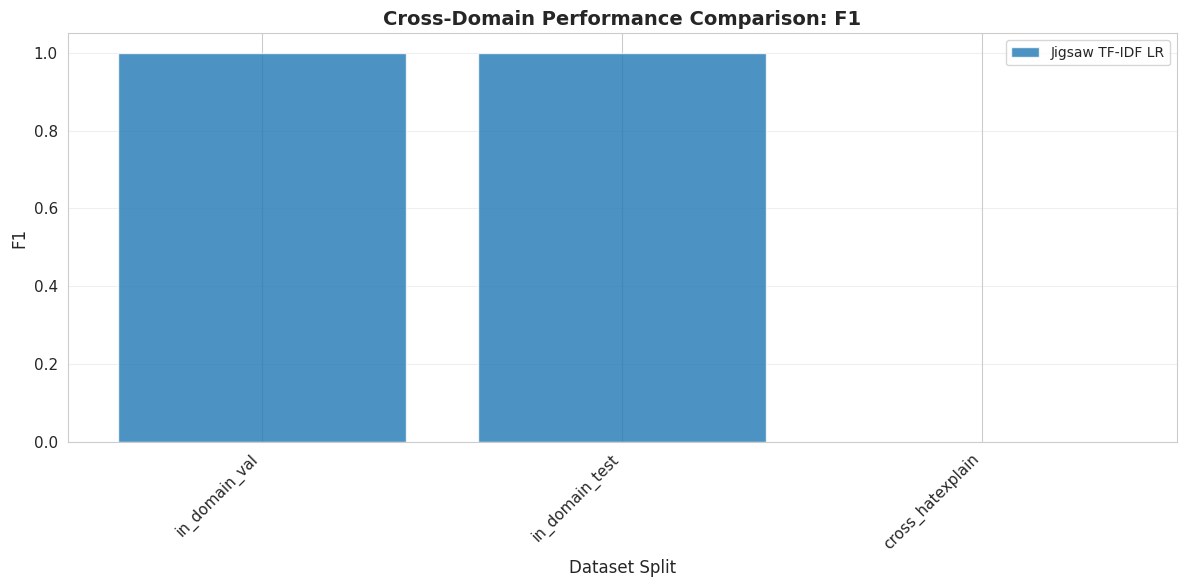

In [10]:
# 5. CROSS-DOMAIN COMPARISON

def plot_cross_domain_comparison(summaries_dict, metric="f1", save_path=None):
    """
    Plot comparison of in-domain vs cross-domain performance.
    
    Args:
        summaries_dict: Dict mapping model_name -> summary DataFrame
        metric: Metric to plot (f1, accuracy, auroc)
        save_path: Where to save
    """
    # Filter out None entries
    valid_summaries = {k: v for k, v in summaries_dict.items() if v is not None}
    
    if not valid_summaries:
        print("[WARN] No valid summary data to plot")
        return
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    width = 0.8 / len(valid_summaries)
    x_labels = []
    
    for idx, (model_name, summary_df) in enumerate(valid_summaries.items()):
        values = []
        labels = []
        
        for _, row in summary_df.iterrows():
            split = row['split']
            val = row.get(metric, np.nan)
            
            if not np.isnan(val):
                values.append(val)
                labels.append(split)
        
        if not x_labels:
            x_labels = labels
        
        x = np.arange(len(values)) + idx * width
        ax.bar(x, values, width, label=model_name, alpha=0.8)
    
    ax.set_xlabel('Dataset Split', fontsize=12)
    ax.set_ylabel(metric.upper(), fontsize=12)
    ax.set_title(f'Cross-Domain Performance Comparison: {metric.upper()}', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(np.arange(len(x_labels)) + width * (len(valid_summaries) - 1) / 2)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example: Compare available models
available_models = {}
if jigsaw_tfidf_lr is not None:
    available_models["Jigsaw TF-IDF LR"] = jigsaw_tfidf_lr
if jigsaw_tfidf_svm is not None:
    available_models["Jigsaw TF-IDF SVM"] = jigsaw_tfidf_svm  
if jigsaw_roberta is not None:
    available_models["Jigsaw RoBERTa"] = jigsaw_roberta

if available_models:
    plot_cross_domain_comparison(
        available_models,
        metric="f1",
        save_path=PLOTS_DIR / "comparison_f1.png"
    )
else:
    print("No model summaries available for comparison")

Saved: /workspaces/ood-eval-toxic-classifiers/experiments/plots/fairness_jigsaw_test.png


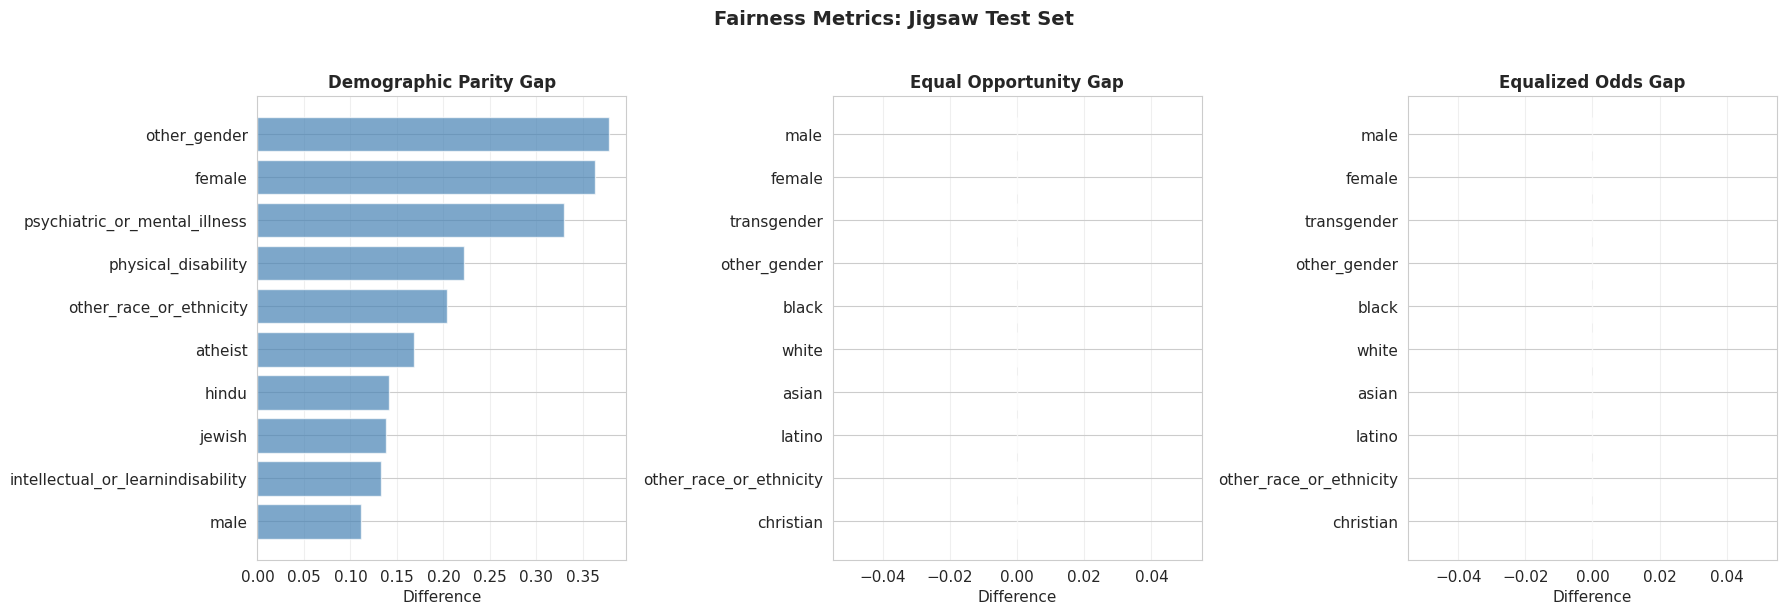

In [11]:
# 6. FAIRNESS METRICS VISUALIZATION

def plot_fairness_summary(fairness_csv_path, title="Fairness Metrics", 
                          top_k=10, save_path=None):
    """
    Plot fairness metrics from summary CSV.
    
    Args:
        fairness_csv_path: Path to fairness summary CSV
        title: Plot title
        top_k: Number of top groups to show
        save_path: Where to save
    """
    df = pd.read_csv(fairness_csv_path)
    
    if len(df) == 0:
        print(f"[WARN] Empty fairness summary: {fairness_csv_path}")
        return
    
    # Get top k groups by DP difference
    df_sorted = df.nlargest(top_k, 'dp_diff')
    
    # Clean group names (remove 'g_' prefix)
    df_sorted['group_name'] = df_sorted['group_col'].str.replace('g_', '')
    
    # Create subplots for each fairness metric
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics = ['dp_diff', 'eop_diff', 'eo_diff']
    titles = ['Demographic Parity Gap', 'Equal Opportunity Gap', 'Equalized Odds Gap']
    colors = ['steelblue', 'orange', 'green']
    
    for ax, metric, plot_title, color in zip(axes, metrics, titles, colors):
        df_metric = df.nlargest(top_k, metric)
        df_metric['group_name'] = df_metric['group_col'].str.replace('g_', '')
        
        ax.barh(df_metric['group_name'], df_metric[metric], color=color, alpha=0.7)
        ax.set_xlabel('Difference', fontsize=11)
        ax.set_title(plot_title, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        ax.invert_yaxis()
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example: Plot fairness metrics
fairness_summary = Path(EXPERIMENTS_DIR) / "fairness_jigsaw_test_summary.csv"
if fairness_summary.exists():
    plot_fairness_summary(
        fairness_summary,
        title="Fairness Metrics: Jigsaw Test Set",
        top_k=10,
        save_path=os.path.join(PLOTS_DIR, "fairness_jigsaw_test.png")
    )

Saved: /workspaces/ood-eval-toxic-classifiers/experiments/plots/per_group_jigsaw_test.png


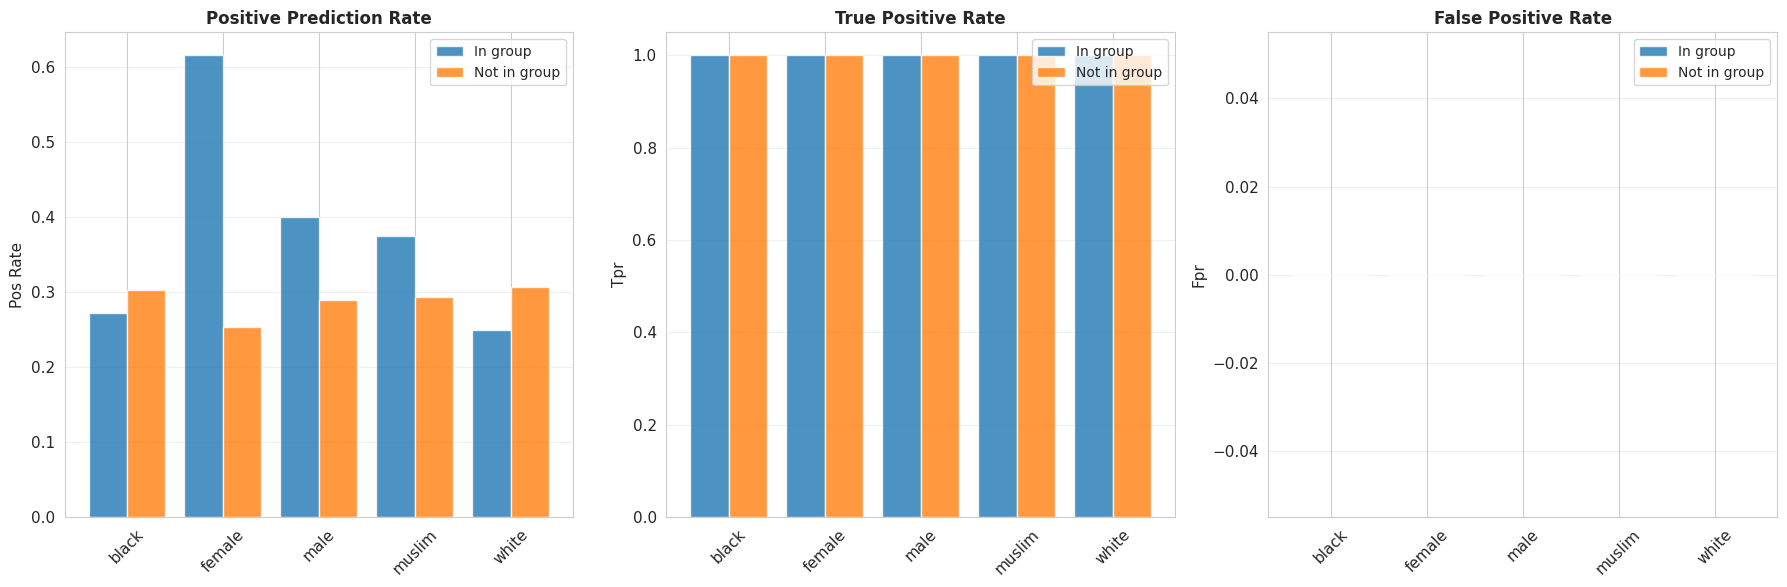

In [12]:
# 7. PER-GROUP FAIRNESS COMPARISON

def plot_per_group_metrics(fairness_per_group_csv, groups_to_plot=None, save_path=None):
    """
    Plot per-group metrics (TPR, FPR, positive rate).
    
    Args:
        fairness_per_group_csv: Path to per-group CSV
        groups_to_plot: List of group names to plot (or None for auto-select)
        save_path: Where to save
    """
    df = pd.read_csv(fairness_per_group_csv)
    
    if len(df) == 0:
        print(f"[WARN] Empty per-group data")
        return
    
    # Auto-select interesting groups if not specified
    if groups_to_plot is None:
        # Select groups with sufficient support and variation
        group_stats = df.groupby('group_col').agg({
            'support': 'sum',
            'tpr': lambda x: x.std(skipna=True)
        })
        group_stats = group_stats[group_stats['support'] > 100]
        groups_to_plot = group_stats.nlargest(6, 'tpr').index.tolist()
    
    # Filter data
    df_plot = df[df['group_col'].isin(groups_to_plot)].copy()
    df_plot['group_name'] = df_plot['group_col'].str.replace('g_', '')
    df_plot['group_val_str'] = df_plot['group_val'].map({0: 'Not in group', 1: 'In group'})
    
    # Create grouped bar chart
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    metrics = ['pos_rate', 'tpr', 'fpr']
    titles = ['Positive Prediction Rate', 'True Positive Rate', 'False Positive Rate']
    
    for ax, metric, plot_title in zip(axes, metrics, titles):
        pivot = df_plot.pivot_table(
            values=metric,
            index='group_name',
            columns='group_val_str',
            aggfunc='first'
        )
        
        pivot.plot(kind='bar', ax=ax, rot=45, alpha=0.8, width=0.8)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
        ax.set_xlabel('')
        ax.set_title(plot_title, fontsize=12, fontweight='bold')
        ax.legend(title='', fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example: Plot per-group metrics
per_group_csv = Path(EXPERIMENTS_DIR) / "fairness_jigsaw_test_per_group.csv"
if per_group_csv.exists():
    plot_per_group_metrics(
        per_group_csv,
        groups_to_plot=['g_male', 'g_female', 'g_black', 'g_white', 'g_lgbtq', 'g_muslim'],
        save_path=os.path.join(PLOTS_DIR, "per_group_jigsaw_test.png")
    )

In [13]:
# 8. CALIBRATION COMPARISON (Before/After)

def plot_calibration_comparison(bins_before_csv, bins_after_csv, save_path=None):
    """
    Compare reliability before and after calibration.
    
    Args:
        bins_before_csv: Path to reliability bins CSV before calibration
        bins_after_csv: Path to reliability bins CSV after calibration
        save_path: Where to save
    """
    df_before = pd.read_csv(bins_before_csv)
    df_after = pd.read_csv(bins_after_csv)
    
    # Filter non-empty bins
    df_before = df_before[df_before['count'] > 0]
    df_after = df_after[df_after['count'] > 0]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    for ax, df, title in zip(axes, [df_before, df_after], 
                              ['Before Calibration', 'After Calibration']):
        ax.scatter(df['conf'], df['acc'], 
                   s=df['count']/df['count'].max()*500,
                   alpha=0.6, c='steelblue', edgecolors='black', linewidths=1)
        ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
        ax.set_xlabel('Confidence', fontsize=12)
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        
        # Add ECE annotation
        ece = df['gap'].mean()
        ax.text(0.05, 0.95, f'ECE = {ece:.4f}', 
                transform=ax.transAxes, fontsize=11,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Note: You would need to save reliability bins before and after calibration
# This is just an example structure

In [14]:
# 9. AGGREGATE METRICS TABLE

def create_metrics_table(summary_dfs_dict, save_path=None):
    """
    Create a formatted table of metrics across models/datasets.
    
    Args:
        summary_dfs_dict: Dict mapping model_name -> summary DataFrame
        save_path: Path to save CSV (optional)
    """
    rows = []
    
    for model_name, df in summary_dfs_dict.items():
        if df is None:
            continue
        
        for _, row in df.iterrows():
            rows.append({
                'Model': model_name,
                'Split': row['split'],
                'Accuracy': f"{row.get('accuracy', np.nan):.4f}",
                'F1': f"{row.get('f1', np.nan):.4f}",
                'AUROC': f"{row.get('auroc', np.nan):.4f}",
                'PR-AUC': f"{row.get('pr_auc', np.nan):.4f}",
                'ECE': f"{row.get('ece', np.nan):.4f}",
            })
    
    results_df = pd.DataFrame(rows)
    
    if save_path:
        results_df.to_csv(save_path, index=False)
        print(f"Saved metrics table to: {save_path}")
    
    return results_df

# Example: Create comprehensive metrics table
metrics_table = create_metrics_table(
    {
        "RoBERTa": jigsaw_roberta,
        "TF-IDF LR": jigsaw_tfidf_lr,
    },
    save_path=os.path.join(EXPERIMENTS_DIR, "metrics_table.csv")
)

display(metrics_table)

Saved metrics table to: /workspaces/ood-eval-toxic-classifiers/experiments/metrics_table.csv


,Model,Split,Accuracy,F1,AUROC,PR-AUC,ECE
0,TF-IDF LR,in_domain_val,1.0000,1.0000,1.0000,1.0000,nan
1,TF-IDF LR,in_domain_test,1.0000,1.0000,1.0000,1.0000,nan
2,TF-IDF LR,cross_hatexplain,0.4043,0.0000,0.4909,0.5878,nan
